In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.unicode_minus'] = False

## 数据预处理

In [35]:
def make_df(fin):
    
    df = pd.read_csv(fin)
    df = df.rename(columns={'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'Natoms',
                            'percent_atom_al' : 'x_Al',
                            'percent_atom_ga' : 'x_Ga',
                            'percent_atom_in' : 'x_In',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'E',
                            'bandgap_energy_ev' : 'Eg'
                            })
    return df

input_dir = "C:/ML/project/chem/"
f_train=input_dir+'train.csv'
df_train = make_df(f_train)
f_test=input_dir+'test.csv'
df_test = make_df(f_test)

df_train.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


### 获得元素性质列表与相应的元素性质

In [36]:
def get_prop_list(path_to_element_data):
    
    return [f[:-4] for f in os.listdir(path_to_element_data)]

path_to_element_data = "C:/ML/project/chem/"+"elemental/"
properties = get_prop_list(path_to_element_data)

In [37]:
def get_prop(prop, path_to_element_data):
    
    fin = os.path.join(path_to_element_data, prop+'.csv')
    with open(fin) as f:
        all_els = {line.split(',')[0] : float(line.split(',')[1][:-1]) for line in f}
        my_els = ['Al', 'Ga', 'In']
        return {el : all_els[el] for el in all_els if el in my_els}
    
prop_dict = {prop : get_prop(prop, path_to_element_data) for prop in properties}

prop_dict

{'EA': {'Al': -0.2563, 'Ga': -0.1081, 'In': -0.3125},
 'HOMO': {'Al': -2.697, 'Ga': -2.732, 'In': -2.784},
 'IP': {'Al': -5.78, 'Ga': -5.8182, 'In': -5.5374},
 'LUMO': {'Al': 0.368, 'Ga': 0.13, 'In': 0.695},
 'electronegativity': {'Al': 1.61, 'Ga': 1.81, 'In': 1.78},
 'mass': {'Al': 26.9815386, 'Ga': 69.723, 'In': 114.818},
 'rd_max': {'Al': 3.11, 'Ga': 2.16, 'In': 1.94},
 'rp_max': {'Al': 1.5, 'Ga': 1.33, 'In': 1.39},
 'rs_max': {'Al': 1.13, 'Ga': 0.99, 'In': 1.09}}

### 根据元素组成得到各元素平均性质

In [38]:
def avg_prop(x_Al, x_Ga, x_In, prop):
 
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [x_Al, x_Ga, x_In]))
    return np.sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

for prop in properties:
    df_train['_'.join(['avg', prop])] = avg_prop(df_train['x_Al'], 
                                                 df_train['x_Ga'],
                                                 df_train['x_In'],
                                                 prop)
    df_test['_'.join(['avg', prop])] = avg_prop(df_test['x_Al'], 
                                                 df_test['x_Ga'],
                                                 df_test['x_In'],
                                                 prop)
    
list(df_train)

['id',
 'sg',
 'Natoms',
 'x_Al',
 'x_Ga',
 'x_In',
 'a',
 'b',
 'c',
 'alpha',
 'beta',
 'gamma',
 'E',
 'Eg',
 'avg_EA',
 'avg_electronegativity',
 'avg_HOMO',
 'avg_IP',
 'avg_LUMO',
 'avg_mass',
 'avg_rd_max',
 'avg_rp_max',
 'avg_rs_max']

### 计算晶胞体积与原子密度

In [39]:
def get_vol(a, b, c, alpha, beta, gamma):
    
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

lattice_angles = ['alpha', 'beta', 'gamma']

for lang in lattice_angles:
    df_train['_'.join([lang, 'r'])] = np.pi * df_train[lang] / 180
    df_test['_'.join([lang, 'r'])] = np.pi * df_test[lang] / 180
    
df_train['vol'] = get_vol(df_train['a'], df_train['b'], df_train['c'],
                          df_train['alpha_r'], df_train['beta_r'], df_train['gamma_r'])

df_train['atomic_density'] = df_train['Natoms'] / df_train['vol']   

df_test['vol'] = get_vol(df_test['a'], df_test['b'], df_test['c'],
                          df_test['alpha_r'], df_test['beta_r'], df_test['gamma_r'])

df_test['atomic_density'] = df_test['Natoms'] / df_test['vol'] 

df_train.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max,alpha_r,beta_r,gamma_r,vol,atomic_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0.278750,43.009587,2.753750,1.436250,1.07750,1.570842,1.570836,1.570826,781.052081,0.102426
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0.278750,43.009587,2.753750,1.436250,1.07750,1.571121,1.570761,2.094439,782.500110,0.102236
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,0.323375,34.995563,2.931875,1.468125,1.10375,1.587705,1.590393,0.532648,391.227531,0.102242
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0.449750,48.940654,2.817500,1.472500,1.12000,1.570601,1.571004,2.094425,293.377334,0.102257
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0.341875,86.633625,2.077500,1.352500,1.02750,1.570727,1.570807,2.094208,944.713843,0.084682


### 对得到的特征可视化分析

#### 原子密度与目标之间的关系

In [44]:
def plot_scatter(x, y, xlabel, ylabel):
    
    s = 75
    lw = 0
    alpha = 0.05
    color = 'orange'
    marker = 'o'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(df_train[x].values, df_train[y].values,
                     marker=marker, color=color, s=s, 
                     lw=lw, alpha=alpha, label=label)
    xrange = abs(df_train[x].max() - df_train[x].min())
    yrange = abs(df_train[y].max() - df_train[y].min())
    cushion = 0.1
    xmin = df_train[x].min() - cushion*xrange
    xmax = df_train[x].max() + cushion*xrange
    ymin = df_train[y].min() - cushion*yrange
    ymax = df_train[y].max() + cushion*yrange
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.xlabel(xlabel, fontsize=fontsize)
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax

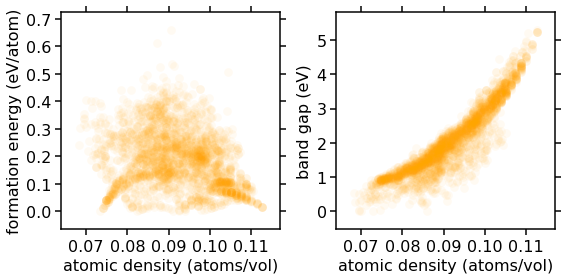

In [45]:
fig1 = plt.figure(1, figsize=(8, 4))
ax1 = plt.subplot(121)
ax1 = plot_scatter('atomic_density', 'E', 
                   'atomic density (atoms/vol)', 'formation energy (eV/atom)')
ax2 = plt.subplot(122)
ax2 = plot_scatter('atomic_density', 'Eg', 
                   'atomic density (atoms/vol)', 'band gap (eV)')
plt.tight_layout()
plt.show()
plt.close()

#### 与元素有关的特征与目标的关系

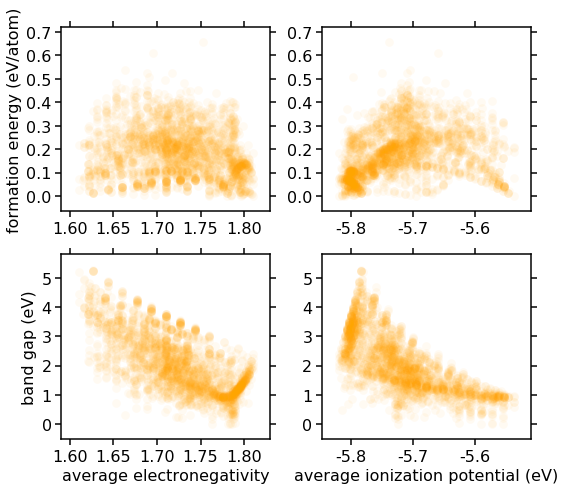

In [46]:
fig2 = plt.figure(2, figsize=(8, 7))
ax1 = plt.subplot(221)
ax1 = plot_scatter('avg_electronegativity', 'E', 
                   '', 'formation energy (eV/atom)')
ax2 = plt.subplot(222)
ax2 = plot_scatter('avg_IP', 'E', 
                   '', '')
ax3 = plt.subplot(223)
ax3 = plot_scatter('avg_electronegativity', 'Eg', 
                   'average electronegativity', 'band gap (eV)')
ax4 = plt.subplot(224)
ax4 = plot_scatter('avg_IP', 'Eg', 
                   'average ionization potential (eV)', '')
plt.tight_layout()
plt.show()
plt.close()

#### 元素组成对平均原子性质的影响

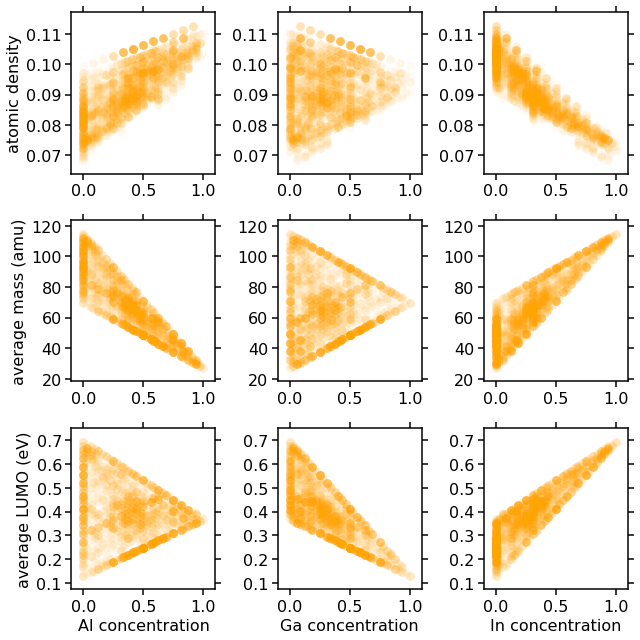

In [47]:
fig3 = plt.figure(3, figsize=(9, 9))
y1_label = 'atomic density'
y2_label = 'average mass (amu)'
y3_label = 'average LUMO (eV)'
ax1 = plt.subplot(331)
ax1 = plot_scatter('x_Al', 'atomic_density', 
                   '', y1_label)
ax2 = plt.subplot(332)
ax2 = plot_scatter('x_Ga', 'atomic_density', 
                   '', '')
ax3 = plt.subplot(333)
ax3 = plot_scatter('x_In', 'atomic_density', 
                   '', '')
ax4 = plt.subplot(334)
ax4 = plot_scatter('x_Al', 'avg_mass', 
                   '', y2_label)
ax5 = plt.subplot(335)
ax5 = plot_scatter('x_Ga', 'avg_mass', 
                   '', '')
ax6 = plt.subplot(336)
ax6 = plot_scatter('x_In', 'avg_mass', 
                   '', '')
ax7 = plt.subplot(337)
ax7 = plot_scatter('x_Al', 'avg_LUMO', 
                   'Al concentration', y3_label)
ax8 = plt.subplot(338)
ax8 = plot_scatter('x_Ga', 'avg_LUMO', 
                   'Ga concentration', '')
ax9 = plt.subplot(339)
ax9 = plot_scatter('x_In', 'avg_LUMO', 
                   'In concentration', '')
plt.tight_layout()
plt.show()
plt.close() 

## 特征工程

利用PCA得到原子构象信息

In [60]:
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D

train=df_train
test=df_test

train_id = train["id"]
test_id = test["id"]
train = train.rename(columns={'E' : 'formation_energy_ev_natom','Eg' : 'bandgap_energy_ev' })
label = train[["formation_energy_ev_natom", "bandgap_energy_ev"]]

train = train.drop(["id", "formation_energy_ev_natom", "bandgap_energy_ev"], axis = 1)
test = test.drop("id", axis = 1)

train.head()

,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max,alpha_r,beta_r,gamma_r,vol,atomic_density
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,0.278750,43.009587,2.753750,1.436250,1.07750,1.570842,1.570836,1.570826,781.052081,0.102426
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.278750,43.009587,2.753750,1.436250,1.07750,1.571121,1.570761,2.094439,782.500110,0.102236
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,0.323375,34.995563,2.931875,1.468125,1.10375,1.587705,1.590393,0.532648,391.227531,0.102242
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,0.449750,48.940654,2.817500,1.472500,1.12000,1.570601,1.571004,2.094425,293.377334,0.102257
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.341875,86.633625,2.077500,1.352500,1.02750,1.570727,1.570807,2.094208,944.713843,0.084682


#### 加载xyz文件

In [61]:
def get_xyz_data(filename, ids):
    
    A = pd.DataFrame(columns=list('ABCDE'))
    B = pd.DataFrame(columns=list('ABCE'))
    
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':

                newrowA = pd.DataFrame([[x[1],x[2],x[3],x[4],ids]], columns=list('ABCDE'))
                A = A.append(newrowA)
                
            elif x[0] == 'lattice_vector':
                
                newrowB = pd.DataFrame([[x[1],x[2],x[3],ids]], columns=list('ABCE'))
                B = B.append(newrowB)

    return A, B

In [73]:
def plot_pca(index):
    
    fn = "C:/ML/project/chem/train/{}/geometry.xyz".format(index)
    train_xyz, train_lat = get_xyz_data(fn, index)
    color_dict = { 'Ga':'black', 'Al':'blue', 'O':'red', 'In':'green' }
    
    matrix = train_xyz
    colour = matrix["D"]
    matrix = matrix[["A","B","C"]].as_matrix()
    matrix = matrix.astype(float)
    
    pca = PCA(n_components=3)
    X_r = pca.fit(matrix).transform(matrix)
    df_ = pd.DataFrame(np.round(X_r,2))
        
    x = np.array(matrix[:,0])
    y = np.array(matrix[:,1])
    z = np.array(matrix[:,2])

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(x,y,z, c=[ color_dict[i] for i in colour ], marker='o', s=70)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(label.loc[index])
    plt.show()
   

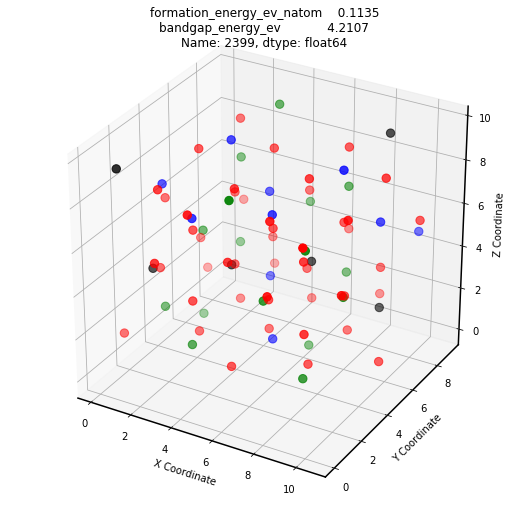

In [76]:
ind=2399
plot_pca(index=ind)

## 建立模型

In [77]:
non_features = ['id', 'E', 'Eg',
               'alpha_r', 'beta_r', 'gamma_r']

features = [col for col in list(df_train) if col not in non_features]
print('%i features: %s' % (len(features), features))

X = df_train[features].values

y_E = df_train['E'].values
y_Eg = df_train['Eg'].values

test_size = 0.2
rstate = 42
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X, y_E, 
                                                            test_size=test_size,
                                                            random_state=rstate)
X_train_Eg, X_test_Eg, y_train_Eg, y_test_Eg = train_test_split(X, y_Eg, 
                                                                test_size=test_size, 
                                                                random_state=rstate)

n_est = 100

max_depth = 5

rstate = 42

rf_E = RandomForestRegressor(n_estimators=n_est, 
                             max_depth=max_depth,
                             random_state=rstate)
rf_Eg = RandomForestRegressor(n_estimators=n_est, 
                             max_depth=max_depth,
                             random_state=rstate)

rf_E.fit(X_train_E, y_train_E)
rf_Eg.fit(X_train_Eg, y_train_Eg)

22 features: ['sg', 'Natoms', 'x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'vol', 'atomic_density']


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [78]:
importances_E =  rf_E.feature_importances_
descending_indices_E = np.argsort(importances_E)[::-1]
sorted_importances_E = [importances_E[idx] for idx in descending_indices_E]
sorted_features_E = [features[idx] for idx in descending_indices_E]
print('most important feature for formation energy is %s' % sorted_features_E[0])

# collect ranking of most "important" features for Eg
importances_Eg =  rf_Eg.feature_importances_
descending_indices_Eg = np.argsort(importances_Eg)[::-1]
sorted_importances_Eg = [importances_Eg[idx] for idx in descending_indices_Eg]
sorted_features_Eg = [features[idx] for idx in descending_indices_Eg]
print('most important feature for band gap is %s' % sorted_features_Eg[0])

most important feature for formation energy is c
most important feature for band gap is atomic_density


RMSLE for formation energies = 0.032 eV/atom (training) and 0.040 eV/atom (test)
RMSLE for band gaps = 0.087 eV (training) and 0.096 eV (test)


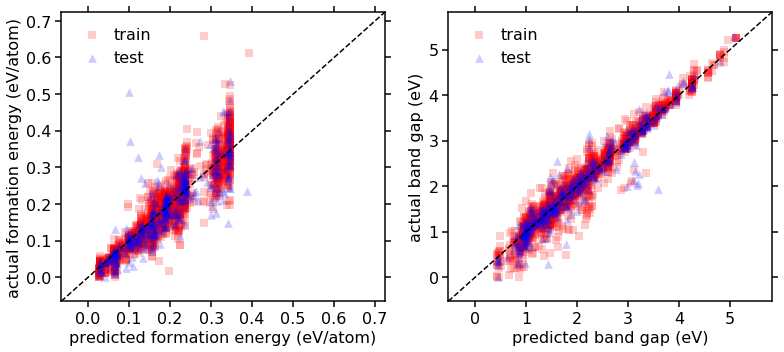

In [83]:
def rmsle(actual, predicted):
  
    return np.sqrt(np.mean(np.power(np.log1p(actual)-np.log1p(predicted), 2)))

def plot_actual_pred(train_actual, train_pred, 
                     test_actual, test_pred,
                     target):
   
    s = 75
    lw = 0
    alpha = 0.2
    train_color = 'red'
    train_marker = 's'
    test_color = 'blue'
    test_marker = '^'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(train_pred, train_actual,
                     marker=train_marker, color=train_color, s=s, 
                     lw=lw, alpha=alpha, label='train')
    ax = plt.scatter(test_pred, test_actual,
                     marker=test_marker, color=test_color, s=s, 
                     lw=lw, alpha=alpha, label='test')
    ax = plt.legend(frameon=False, fontsize=fontsize, handletextpad=0.4)    
    all_vals = list(train_pred) + list(train_actual) + list(test_pred) + list(test_actual)
    full_range = abs(np.max(all_vals) - np.min(all_vals))
    cushion = 0.1
    xmin = np.min(all_vals) - cushion*full_range
    xmax = np.max(all_vals) + cushion*full_range
    ymin = xmin
    ymax = xmax    
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.plot([xmin, xmax], [ymin, ymax], 
                  lw=axis_width, color='black', ls='--', 
                  label='__nolegend__')
    ax = plt.xlabel('predicted ' + target, fontsize=fontsize)
    ax = plt.ylabel('actual ' + target, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax  

y_train_E_pred = rf_E.predict(X_train_E)
y_test_E_pred = rf_E.predict(X_test_E)
target_E = 'formation energy (eV/atom)'
print('RMSLE for formation energies = %.3f eV/atom (training) and %.3f eV/atom (test)' 
      % (rmsle(y_train_E, y_train_E_pred),  (rmsle(y_test_E, y_test_E_pred))))
y_train_Eg_pred = rf_Eg.predict(X_train_Eg)
y_test_Eg_pred = rf_Eg.predict(X_test_Eg)
target_Eg = 'band gap (eV)'
print('RMSLE for band gaps = %.3f eV (training) and %.3f eV (test)' 
      % (rmsle(y_train_Eg, y_train_Eg_pred), (rmsle(y_test_Eg, y_test_Eg_pred))))
fig4 = plt.figure(4, figsize=(11,5))
ax1 = plt.subplot(121)
ax1 = plot_actual_pred(y_train_E, y_train_E_pred,
                       y_test_E, y_test_E_pred,
                       target_E)
ax2 = plt.subplot(122)
ax2 = plot_actual_pred(y_train_Eg, y_train_Eg_pred,
                       y_test_Eg, y_test_Eg_pred,
                       target_Eg)
plt.tight_layout()
plt.show()
plt.close()